<a href="https://colab.research.google.com/github/1n1n1t3/Coral-Dev-Board/blob/master/EfficientNet_EdgeTPU_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nightly build mandatory else errors

---



In [0]:
#!pip install tensorflow-gpu==2.0.0-beta0
#!pip instaell tf-nightly-gpu

! pip uninstall -y tensorflow
! pip install -U tf-nightly-gpu


import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils
#tf.enable_eager_execution()

print(tf.__version__)

Uninstalling tensorflow-1.14.0rc1:
  Successfully uninstalled tensorflow-1.14.0rc1
     |████████████████████████████████| 372.2MB 50kB/s 
     |████████████████████████████████| 501kB 44.9MB/s 
     |████████████████████████████████| 3.2MB 48.9MB/s 
1.14.1-dev20190616


Using TensorFlow backend.


# Preparation

Test with cifar10

In [0]:
cifar10 = keras.datasets.cifar10
(trainX, trainY), (testX, testY) = cifar10.load_data()

testLabels = testY
trainLabels = trainY
trainImages = trainX
testImages = testX

trainX = trainX.reshape((trainX.shape[0], 32, 32, 3))
testX = testX.reshape((testX.shape[0], 32, 32, 3))

trainX = trainX / 255.0
testX = testX / 255.0
# one-hot encode the training and testing labels
trainY = np_utils.to_categorical(trainY, 10)
testY = np_utils.to_categorical(testY, 10)
# initialize the label names
labelNames = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170500096/170498071 [==============================] - 9s 0us/step


Get efficientnet implementation playing nice with tf.keras


In [0]:
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
  !git clone https://github.com/Tony607/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/
#
# #for tf 2.0
#!tf_upgrade_v2 --infile efficientnet/model.py --outfile efficientnet/model.py
#!tf_upgrade_v2 --infile efficientnet/initializers.py --outfile efficientnet/initializers.py
#!tf_upgrade_v2 --infile efficientnet/layers.py --outfile efficientnet/layers.py
#!tf_upgrade_v2 --infile efficientnet/params.py --outfile efficientnet/params.py
#!tf_upgrade_v2 --infile efficientnet/preprocessing.py --outfile efficientnet/preprocessing.py

/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 171 (delta 98), reused 161 (delta 93), pack-reused 0
Receiving objects: 100% (171/171), 5.44 MiB | 4.25 MiB/s, done.
Resolving deltas: 100% (98/98), done.
/content/efficientnet_keras_transfer_learning


In [0]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB3 as Net
from efficientnet import center_crop_and_resize, preprocess_input

from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

Params and Model

In [0]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.optimizers import SGD

imgindex = 25

NUM_EPOCHS = 200
INIT_LR = 0.0065
BS = 500
chanDim = -1
classes = 10
width = 32
height = 32
input_shape = (height, width, 3)

def build_keras_model():
  
    #return keras.Sequential([
    #        keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape),
    #        keras.layers.BatchNormalization(),
    #        keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    #        keras.layers.BatchNormalization(),
    #        keras.layers.MaxPooling2D((2, 2)),
    #        keras.layers.Dropout(0.2),
    #        keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    #        keras.layers.BatchNormalization(),
    #        keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    #        keras.layers.BatchNormalization(),
    #        keras.layers.MaxPooling2D((2, 2)),
    #        keras.layers.Dropout(0.3),
    #        keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    #        keras.layers.BatchNormalization(),
    #        keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    #        keras.layers.BatchNormalization(),
    #        keras.layers.MaxPooling2D((2, 2)),
    #        keras.layers.Dropout(0.4),
    #        keras.layers.Flatten(),
    #        keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform'),
    #        keras.layers.BatchNormalization(),
    #        keras.layers.Dropout(0.5),
    #        keras.layers.Dense(classes, activation='softmax', name="fc_outfc_out")      
    #])
    model = keras.Sequential()
    conv_base = Net(weights='imagenet',include_top=False, input_shape=input_shape)
    conv_base.trainable = True
    #count = -1
    #set_trainable = False
    #for layer in conv_base.layers:
    #  count = count + 1
    #  #print(str(layer.name)+" - "+str(count))
    #  if layer.name == 'multiply_23':
    #      set_trainable = True
    #  if set_trainable:
    #      layer.trainable = True
    #  else:
    #      layer.trainable = False
    model.add(conv_base)
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(classes, activation='softmax', name="output"))
    return model



Image transformation

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      channel_shift_range=0.2,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
        trainX,trainY,
        batch_size=BS)

validation_generator = test_datagen.flow(
        testX,testY,
        batch_size=BS)

In [0]:
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

#Train

In [0]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
#tf.compat.v1.disable_eager_execution()


get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})
train_model = build_keras_model()   

W0616 20:31:45.461189 140043396921216 deprecation_wrapper.py:118] From /content/efficientnet_keras_transfer_learning/efficientnet/model.py:67: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0616 20:31:46.319335 140043396921216 deprecation_wrapper.py:118] From /usr/local/lib/python3.6/dist-packages/tensorflow_estimator/python/estimator/api/_v1/estimator/__init__.py:10: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.

W0616 20:31:46.907497 140043396921216 deprecation_wrapper.py:118] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/autograph/converters/directives.py:119: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0616 20:31:47.012965 140043396921216 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/autograph/impl/api.py:328: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version

43974656/43966704 [==============================] - 3s 0us/step


In [0]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=25, verbose=1)
opt = optimizers.SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
train_model.compile(loss="categorical_crossentropy", optimizer="adam",  metrics=["accuracy"])
train_model.summary()
history = train_model.fit_generator(
      train_generator,
      steps_per_epoch= np.shape(trainX)[0] //BS,
      epochs=NUM_EPOCHS,
      validation_data=validation_generator,
      validation_steps= np.shape(testX)[0] //BS, callbacks=[early_stop],
      verbose=1)#,
      #use_multiprocessing=True,
      #workers=4) 

train_model.save("model.h5")
predictions = train_model.predict(testX)

#for op in train_graph .get_operations(): 
#  print(op.name)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 1, 1, 1536)        10783528  
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
output (Dense)               (None, 10)                15370     
Total params: 10,798,898
Trainable params: 10,711,602
Non-trainable params: 87,296
_________________________________________________________________
Epoch 1/200
100/100 [==============================] - 78s 776ms/step - loss: 1.6666 - acc: 0.4018 - val_loss: 2.4760 - val_acc: 0.1000
Epoch 2/200
100/100 [==============================] - 34s 343ms/step - loss: 1.1268 - acc: 0.6042 - 

Display history

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


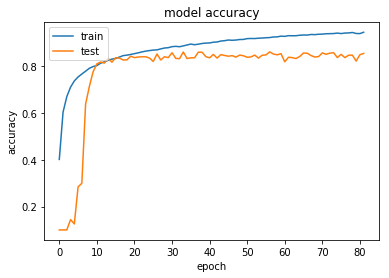

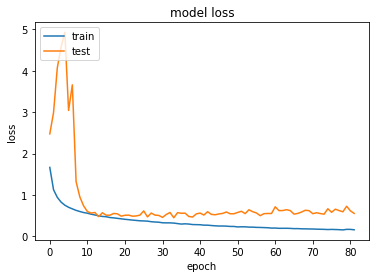

In [0]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Test prediction

[  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.]


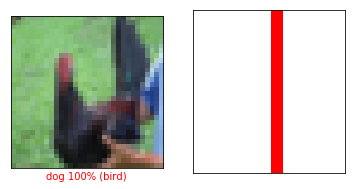

In [0]:
print(predictions[imgindex]*100)
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  true_label = np.argmax(true_label)
  plt.imshow(img)
  
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(labelNames[predicted_label],
                                100*np.max(predictions_array),
                                labelNames[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  true_label = np.argmax(true_label)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')
  

#print(np.shape(testY))
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(imgindex, predictions, testY, testX)
plt.subplot(1,2,2)
plot_value_array(imgindex, predictions,  testY)
plt.show()

# Convert

In [0]:
from tensorflow.keras.models import load_model
#import tf.compat.v2.lite.OpsSet as OpsSet
#tf.enable_eager_execution()
#tf.logging.set_verbosity(tf.logging.DEBUG)
#import tensorflow.compat.v2 as tfl
#import tensorflow.contrib.eager as tfe
#from tensorflow.python.eager.context import eager_mode, graph_mode

#mport tensorflow.compat.v1 as tf
#tf.reset_default_graph()
#tf.disable_v2_behavior()

#model = load_model("model.h5")
converter = tf.lite.TFLiteConverter.from_keras_model_file("model.h5") 

#tf.reset_default_graph()
#tf.enable_v2_behavior()

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

num_calibration_steps = 100



dstrain, _ = cifar10.load_data()
images = tf.cast(dstrain[0], tf.float32)/255.0
cifar_ds = tf.data.Dataset.from_tensor_slices((images)).batch(1)

#for tf 2.0
def representative_dataset_gen():
    for input_value in cifar_ds.take(num_calibration_steps):
      yield [input_value]

def representative_img_gen():
  repImg = trainX[:100]
  repImg = np.array(repImg, dtype=np.float32)
  for img in repImg:
      img = img.reshape((1,32,32,3))
      yield[img]
  
  
converter.representative_dataset = tf.lite.RepresentativeDataset(
    representative_img_gen)

qmodelname = "qmodel.tflite"

tflite_quant_model = converter.convert()
open(qmodelname, "wb").write(tflite_quant_model)


W0616 21:21:56.445170 140043396921216 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0616 21:21:56.450697 140043396921216 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0616 21:22:01.661824 140043396921216 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dt

12502360

Test converted model

In [0]:
import numpy as np
from PIL import Image
import os

imgindex =12
#iLoad TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=qmodelname)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)
# Test model on random input data.

img = testX[imgindex]
img = np.array([img], dtype=np.float32)
#print(img)
#img = img.astype(np.uint8)
#img = img.reshape(1,32,32,3)

#quantized_input = quantize(input_details[0], img)


print(np.shape(img))


interpreter.set_tensor(input_details[0]['index'], img)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
# View
print(output_data)
#output = dequantize(output_details[0], output_data)
output = output_data[0]
#print( output)
res = np.argmax(output, axis=0)
print(res)
print(labelNames[res])
print(np.argmax(testY[imgindex], axis=0))
print(labelNames[np.argmax(testY[imgindex], axis=0)])


img = testImages[imgindex].reshape(32,32,3)
print(np.shape(img))
plt.figure()
plt.imshow(testImages[imgindex])
plt.colorbar()
plt.grid(False)
plt.show()

#EdgeTPU compiler

In [0]:
%%bash

echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
sudo apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 6A030B21BA07F4FB

sudo apt update > /dev/null
sudo apt install edgetpu > /dev/null

In [0]:
%%bash

edgetpu_compiler -s "qmodel.tflite"